<a href="https://colab.research.google.com/github/fakhrzakbar/Project--/blob/main/analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance and Aptitude Analysis
# The Key English Course Company - Indonesia

### A Comprehensive Data-Driven Study

**Analysis Date:** January 13, 2026
**Total Students:** 150 (50 per course level)
**Variables Analyzed:** Performance Scores, Aptitude Scores
**Statistical Methods:** ANOVA, Correlation, Effect Sizes, Post-Hoc Tests#


# Chapter 1: Environment Setup

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Chapter 2: Data Loading and Overview

In [24]:
df = pd.read_csv('student_combined_data.csv')
print("Combined Data Shape:", df.shape)
display(df.head())
print("\nData Info:")
df.info()

Combined Data Shape: (150, 4)


,student_id,course_level,performance_score,aptitude_score
0,1,Advanced,3.70,72
1,2,Advanced,3.65,90
2,3,Advanced,3.55,68
3,4,Advanced,3.45,84
4,5,Advanced,3.55,72



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_id         150 non-null    int64  
 1   course_level       150 non-null    object 
 2   performance_score  150 non-null    float64
 3   aptitude_score     150 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 4.8+ KB


# Chapter 3: Descriptive Statistics by Course Level

In [25]:
print("--- Descriptive Statistics for All Columns (Excluding student_id) ---")
display(df.drop(columns=['student_id']).describe())

print("\n--- Performance Score Stats by Course Level ---")
perf_stats = df.groupby("course_level", observed=False)["performance_score"].describe()
display(perf_stats)

print("\n--- Aptitude Score Stats by Course Level ---")
apt_stats = df.groupby("course_level", observed=False)["aptitude_score"].describe()
display(apt_stats)

--- Descriptive Statistics for All Columns (Excluding student_id) ---


,performance_score,aptitude_score
count,150.00,150.00
mean,2.54,44.24
std,0.65,24.23
min,1.55,9.00
25%,1.95,22.00
50%,2.48,38.00
75%,3.04,65.00
max,3.80,97.00



--- Performance Score Stats by Course Level ---


,count,mean,std,min,25%,50%,75%,max
course_level,,,,,,,,
Advanced,50.00,3.24,0.38,2.50,2.95,3.38,3.55,3.80
Foundation,50.00,1.87,0.18,1.55,1.75,1.83,1.95,2.45
Intermediate,50.00,2.52,0.39,1.90,2.25,2.48,2.79,3.55



--- Aptitude Score Stats by Course Level ---


,count,mean,std,min,25%,50%,75%,max
course_level,,,,,,,,
Advanced,50.00,67.46,19.17,30.00,50.00,70.00,83.00,97.00
Foundation,50.00,22.52,7.03,9.00,17.25,21.00,26.00,41.00
Intermediate,50.00,42.74,18.28,14.00,31.00,41.50,53.50,90.00


In [26]:
# --- Calculate Basic Statistics ---
# We select the two relevant columns and use .agg to get most stats at once
overall_stats = df[['performance_score', 'aptitude_score']].agg(['mean', 'median', 'min', 'max'])

# --- Calculate "Range" (Spread) ---
# Range isn't a built-in pandas string function, so we calculate it manually
# Range = Max - Min
overall_stats.loc['range'] = overall_stats.loc['max'] - overall_stats.loc['min']

# --- Cleaning Up the Table ---
# Rename the Index to match your "Academic" labels
row_labels = {
    'mean': 'Average (Mean)',
    'median': 'Middle Value (Median)',
    'min': 'Lowest Score',
    'max': 'Highest Score',
    'range': 'Spread (Range)'
}
overall_stats = overall_stats.rename(index=row_labels)

# ---. Formatting ---
# Round Performance to 2 decimals and Aptitude to 2 decimals
# (You can adjust this if you want Aptitude to be integers)
pd.options.display.float_format = '{:,.2f}'.format

# --- Display ---
display(overall_stats)

,performance_score,aptitude_score
Average (Mean),2.54,44.24
Middle Value (Median),2.48,38.00
Lowest Score,1.55,9.00
Highest Score,3.80,97.00
Spread (Range),2.25,88.00


In [27]:
# --- Calculate Basic Statistics ---
# Group by 'course_level' and calculate count, mean, min, max, and std dev
stats = df.groupby('course_level')['performance_score'].agg(['count', 'mean', 'min', 'max', 'std'])

# --- Calculate "Typical Range" (Mean +/- SD) ---
# We calculate the lower and upper bounds
stats['lower'] = stats['mean'] - stats['std']
stats['upper'] = stats['mean'] + stats['std']

# Combine them into a single string column "
stats['Typical Range'] = (
    stats['lower'].map('{:.2f}'.format) + ' - ' +
    stats['upper'].map('{:.2f}'.format)
)

# ---  Formatting & Cleaning ---
# Rename columns to match your Table 2 headers
stats = stats.rename(columns={
    'count': 'Students',
    'mean': 'Average',
    'min': 'Lowest',
    'max': 'Highest'
})

# Select only the columns we want to display
final_table = stats[['Students', 'Average', 'Lowest', 'Highest', 'Typical Range']]

# Reorder the rows to match your image (Advanced -> Intermediate -> Foundation)
final_table = final_table.reindex(['Advanced', 'Intermediate', 'Foundation'])

# Apply formatting to the numeric columns (2 decimal places)
# Note: 'Students' is an integer, so we don't apply float format to it.
pd.options.display.float_format = '{:.2f}'.format

# ---  Display ---
print("Performance Scores Across Course Levels")
display(final_table)

Performance Scores Across Course Levels


,Students,Average,Lowest,Highest,Typical Range
course_level,,,,,
Advanced,50,3.24,2.50,3.80,2.85 - 3.62
Intermediate,50,2.52,1.90,3.55,2.13 - 2.91
Foundation,50,1.86,1.55,2.45,1.69 - 2.04


In [28]:
# ---  Calculate Basic Statistics ---
# Group by 'course_level' and calculate stats for 'aptitude_score'
stats = df.groupby('course_level')['aptitude_score'].agg(['count', 'mean', 'min', 'max', 'std'])

# --- 3. Calculate "Typical Range" (Mean +/- Standard Deviation) ---
# The image shows the range values as Integers (e.g., "48 - 86"), so we round them.
stats['lower'] = (stats['mean'] - stats['std']).round(0).astype(int)
stats['upper'] = (stats['mean'] + stats['std']).round(0).astype(int)

# Create the "Int - Int" string format
stats['Typical Range'] = (
    stats['lower'].astype(str) + ' - ' +
    stats['upper'].astype(str)
)

# --- 4. Formatting & Cleaning ---
# Rename columns to match Table 3
stats = stats.rename(columns={
    'count': 'Students',
    'mean': 'Average',
    'min': 'Lowest',
    'max': 'Highest'
})

# Reorder rows (Advanced -> Intermediate -> Foundation)
stats = stats.reindex(['Advanced', 'Intermediate', 'Foundation'])

# Select only the specific columns shown in the image
final_table = stats[['Students', 'Average', 'Lowest', 'Highest', 'Typical Range']]

# --- 5. Final Display Settings ---
# Ensure 'Average' displays with 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

print("Aptitude Scores Across Course Levels")
display(final_table)

Aptitude Scores Across Course Levels


,Students,Average,Lowest,Highest,Typical Range
course_level,,,,,
Advanced,50,67.46,30,97,48 - 87
Intermediate,50,42.74,14,90,24 - 61
Foundation,50,22.52,9,41,15 - 30


# Chapter 4: Statistical Assumption Testing

In [29]:
from scipy import stats
# --- Normality Test (Shapiro-Wilk) ---
# We check normality for each group separately because ANOVA assumes
# the residuals are normal (or groups are normal).
normality_results = []

for level in ['Advanced', 'Intermediate', 'Foundation']:
    # Get Performance Scores for this level
    subset = df[df['course_level'] == level]['performance_score']

    # Run Shapiro-Wilk Test
    stat, p_val = stats.shapiro(subset)

    # Intepretation: If p > 0.05, it looks Normal. If p < 0.05, it is NOT Normal.
    result = "Normal" if p_val > 0.05 else "Not Normal"

    normality_results.append({
        'Test': f"Shapiro-Wilk ({level})",
        'Statistic': f"{stat:.3f}",
        'p-value': f"{p_val:.3f}",
        'Conclusion': result
    })

# --- Homogeneity of Variance (Levene's Test) ---
# This checks if the "spread" is consistent across all three groups
group1 = df[df['course_level'] == 'Advanced']['performance_score']
group2 = df[df['course_level'] == 'Intermediate']['performance_score']
group3 = df[df['course_level'] == 'Foundation']['performance_score']

stat, p_val = stats.levene(group1, group2, group3)
result = "Variances are Equal" if p_val > 0.05 else "Variances are Different"

# Add Levene's result to the list
normality_results.append({
    'Test': "Levene's Test (Homogeneity)",
    'Statistic': f"{stat:.3f}",
    'p-value': f"{p_val:.3f}",
    'Conclusion': result
})

# --- Create and Display Table ---
results_df = pd.DataFrame(normality_results)

# Display Options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

print("Statistical Assumption Testing")
print("-" * 60)
display(results_df)

Statistical Assumption Testing
------------------------------------------------------------


,Test,Statistic,p-value,Conclusion
0,Shapiro-Wilk (Advanced),0.909,0.001,Not Normal
1,Shapiro-Wilk (Intermediate),0.955,0.053,Normal
2,Shapiro-Wilk (Foundation),0.949,0.031,Not Normal
3,Levene's Test (Homogeneity),16.599,0.000,Variances are Different


# Chapter 5: One-Way ANOVA Analysis

In [30]:
import pandas as pd
from scipy import stats

# --- 1. Load Data ---
df = pd.read_csv('student_combined_data.csv')

# --- 2. Prepare Data for ANOVA ---
# We separate the performance scores into 3 arrays based on the group
group_advanced = df[df['course_level'] == 'Advanced']['performance_score']
group_inter = df[df['course_level'] == 'Intermediate']['performance_score']
group_found = df[df['course_level'] == 'Foundation']['performance_score']

# --- 3. Run the One-Way ANOVA ---
f_stat, p_val = stats.f_oneway(group_advanced, group_inter, group_found)

# --- 4. Calculate Effect Size (Eta Squared) manually ---
# Scipy doesn't calculate this automatically, so we do the math:
# Eta^2 = Sum of Squares Between / Sum of Squares Total

# Grand Mean (Mean of ALL students)
grand_mean = df['performance_score'].mean()

# Sum of Squares Total (SST)
ss_total = ((df['performance_score'] - grand_mean) ** 2).sum()

# Sum of Squares Between (SSB)
ss_between = 0
for group in [group_advanced, group_inter, group_found]:
    n = len(group)
    group_mean = group.mean()
    ss_between += n * (group_mean - grand_mean)**2

eta_squared = ss_between / ss_total

# --- 5. Display Results ---
print("One-Way ANOVA Analysis Results (Performance)")
print("-" * 50)
print(f"Variable Tested: Performance Score")
print(f"F-Statistic:     {f_stat:.2f}")

# Format P-value to be readable
if p_val < 0.001:
    print(f"P-Value:         < 0.001 (Highly Significant)")
else:
    print(f"P-Value:         {p_val:.4f}")

print(f"Effect Size (η²): {eta_squared:.3f}")

# Interpretation
print("-" * 50)
print("Conclusion:")
if p_val < 0.05:
    print("There is a statistically significant difference between the groups.")
    print(f"The Course Level explains {eta_squared*100:.1f}% of the variance in scores.")
else:
    print("No significant difference found between the groups.")

One-Way ANOVA Analysis Results (Performance)
--------------------------------------------------
Variable Tested: Performance Score
F-Statistic:     213.43
P-Value:         < 0.001 (Highly Significant)
Effect Size (η²): 0.744
--------------------------------------------------
Conclusion:
There is a statistically significant difference between the groups.
The Course Level explains 74.4% of the variance in scores.


In [31]:
import pandas as pd
from scipy import stats

# --- 1. Load Data ---
df = pd.read_csv('student_combined_data.csv')

# --- 2. Prepare Data for ANOVA (Aptitude) ---
# Separate aptitude scores into 3 groups
apt_advanced = df[df['course_level'] == 'Advanced']['aptitude_score']
apt_inter = df[df['course_level'] == 'Intermediate']['aptitude_score']
apt_found = df[df['course_level'] == 'Foundation']['aptitude_score']

# --- 3. Run One-Way ANOVA ---
f_stat, p_val = stats.f_oneway(apt_advanced, apt_inter, apt_found)

# --- 4. Calculate Effect Size (Eta Squared) ---
# Formula: SS_Between / SS_Total

# Grand Mean (Average of ALL aptitude scores)
grand_mean = df['aptitude_score'].mean()

# Sum of Squares Total (SST)
ss_total = ((df['aptitude_score'] - grand_mean) ** 2).sum()

# Sum of Squares Between (SSB)
ss_between = 0
for group in [apt_advanced, apt_inter, apt_found]:
    n = len(group)
    group_mean = group.mean()
    ss_between += n * (group_mean - grand_mean)**2

eta_squared = ss_between / ss_total

# --- 5. Display Results ---
print("One-Way ANOVA Analysis Results (Aptitude)")
print("-" * 50)
print(f"Variable Tested: Aptitude Score")
print(f"F-Statistic:     {f_stat:.2f}")

# Format P-value
if p_val < 0.001:
    print(f"P-Value:         < 0.001 (Highly Significant)")
else:
    print(f"P-Value:         {p_val:.4f}")

print(f"Effect Size (η²): {eta_squared:.3f}")

# Interpretation
print("-" * 50)
print("Conclusion:")
if p_val < 0.05:
    print("There is a statistically significant difference in Aptitude between the levels.")
    print(f"The Course Level explains {eta_squared*100:.1f}% of the variance in aptitude scores.")
else:
    print("No significant difference found between the groups.")

One-Way ANOVA Analysis Results (Aptitude)
--------------------------------------------------
Variable Tested: Aptitude Score
F-Statistic:     101.17
P-Value:         < 0.001 (Highly Significant)
Effect Size (η²): 0.579
--------------------------------------------------
Conclusion:
There is a statistically significant difference in Aptitude between the levels.
The Course Level explains 57.9% of the variance in aptitude scores.


# Chapter 6: Post-Hoc Tests (Tukey HSD)

In [41]:
# ==========================================
# PART A: Tukey HSD for Performance Scores
# ==========================================
print("Tukey HSD Results: Performance Scores")
print("-" * 50)

# Run the test
# endog = data (scores), groups = group labels (levels)
tukey_perf = pairwise_tukeyhsd(endog=df['performance_score'],
                               groups=df['course_level'],
                               alpha=0.05)

# Display the results table
print(tukey_perf)


# ==========================================
# PART B: Tukey HSD for Aptitude Scores
# ==========================================
print("\n" + "="*50 + "\n")
print("6.2 Tukey HSD Results: Aptitude Scores")
print("-" * 50)

# Run the test
tukey_apt = pairwise_tukeyhsd(endog=df['aptitude_score'],
                              groups=df['course_level'],
                              alpha=0.05)

# Display the results table
print(tukey_apt)

# --- Optional: Convert to Pandas DataFrame for cleaner view ---
# If you want to use the data later or display it prettier:
# perf_df = pd.DataFrame(data=tukey_perf._results_table.data[1:],
#                        columns=tukey_perf._results_table.data[0])
# print("\n(Pandas DataFrame Version):")
# print(perf_df)

Tukey HSD Results: Performance Scores
--------------------------------------------------
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1      group2    meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
  Advanced   Foundation   -1.374   0.0 -1.5315 -1.2165   True
  Advanced Intermediate   -0.721   0.0 -0.8785 -0.5635   True
Foundation Intermediate    0.653   0.0  0.4955  0.8105   True
-------------------------------------------------------------


6.2 Tukey HSD Results: Aptitude Scores
--------------------------------------------------
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj  lower    upper   reject
---------------------------------------------------------------
  Advanced   Foundation   -44.94   0.0 -52.4329 -37.4471   True
  Advanced Intermediate   -24.72   0.0 -32.2129 -17.2271   True
Foundation Intermediate    20.22   0.0  12.7271  27.7129   True
-

In [42]:
import pandas as pd
import numpy as np
from scipy import stats

# ---  Define Helper Function for Cohen's d ---
# Cohen's d measures the "standardized mean difference"
def calculate_cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    # Calculate sample variances (ddof=1)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Calculate Pooled Standard Deviation
    numerator = ((n1 - 1) * var1) + ((n2 - 1) * var2)
    denominator = n1 + n2 - 2
    pooled_sd = np.sqrt(numerator / denominator)

    # Calculate Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_sd
    return d

# --- 3. Define Interpretation Logic ---
def get_interpretation(d_value):
    abs_d = abs(d_value)
    if abs_d >= 1.2:
        return "Very Large"
    elif abs_d >= 0.8:
        return "Large"
    elif abs_d >= 0.5:
        return "Medium"
    elif abs_d >= 0.2:
        return "Small"
    else:
        return "Negligible"

# ---  Perform Comparisons and Build Table Data ---
# Define the specific pairs to compare
comparisons = [
    ('Advanced', 'Intermediate'),
    ('Intermediate', 'Foundation'),
    ('Advanced', 'Foundation')
]

rows = []

for label1, label2 in comparisons:
    # Isolate the data for the two groups being compared
    g1 = df[df['course_level'] == label1]['performance_score']
    g2 = df[df['course_level'] == label2]['performance_score']

    # A. Calculate raw difference
    diff = g1.mean() - g2.mean()

    # B. Calculate p-value (Independent t-test)
    t_stat, p_val = stats.ttest_ind(g1, g2)

    # C. Calculate Effect Size (Cohen's d)
    d_val = calculate_cohens_d(g1, g2)

    # D. Determine Interpretation string
    interpret_str = get_interpretation(d_val)

    # --- Formatting rows to match image ---
    formatted_row = {
        'Comparison': f"{label1} vs {label2}",
        'Difference': f"{diff:.2f} points",
        # Format p-value to "<0.001" if extremely small
        'p-value': "<0.001" if p_val < 0.001 else f"{p_val:.3f}",
        'Effect Size': f"{d_val:.2f}",
        'Interpretation': interpret_str
    }
    rows.append(formatted_row)

# ---  Create and Display Pandas DataFrame ---
results_df = pd.DataFrame(rows)

# Set display options to make sure columns don't get cut off
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Print Titles
print("Comparing Specific Pairs of Levels\n")
print("Pairwise Performance Comparisons")
# Print the Table
print(results_df.to_string(index=False))

Comparing Specific Pairs of Levels

Pairwise Performance Comparisons
                Comparison  Difference p-value Effect Size Interpretation
  Advanced vs Intermediate 0.72 points  <0.001        1.86     Very Large
Intermediate vs Foundation 0.65 points  <0.001        2.15     Very Large
    Advanced vs Foundation 1.37 points  <0.001        4.60     Very Large


# Chapter 7: Correlation Analysis

In [34]:
# --- Calculate Correlation Statistics ---
# Pearson correlation returns the coefficient (r) and the p-value
r, p_value = stats.pearsonr(df['aptitude_score'], df['performance_score'])

# Calculate Shared Variance (Coefficient of Determination, r-squared)
# This represents the percentage of variation in one variable explained by the other
shared_variance = r ** 2

# --- 3. Build the Table Data ---
# We manually construct the rows to match the specific format of your image
data = [
    {
        'Relationship': 'Aptitude <-> Performance',
        'Correlation (r)': f"{r:.3f}",
        'Interpretation': 'Very Strong Positive' # Interpretation based on r > 0.8
    },
    {
        'Relationship': 'Statistical Significance',
        'Correlation (r)': 'p < 0.001' if p_value < 0.001 else f"{p_value:.4f}",
        'Interpretation': 'Extremely Confident' # Interpretation based on p < 0.001
    },
    {
        'Relationship': 'Shared Variance',
        'Correlation (r)': f"{shared_variance*100:.1f}%",
        'Interpretation': 'High Predictability' # Interpretation based on high r-squared
    }
]

# ---  Create and Display Table ---
results_df = pd.DataFrame(data)

# Adjust pandas settings to ensure the long text sentences don't get cut off
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
print("Correlation Between Aptitude and Performance")
display(results_df)

Correlation Between Aptitude and Performance


,Relationship,Correlation (r),Interpretation
0,Aptitude <-> Performance,0.887,Very Strong Positive
1,Statistical Significance,p < 0.001,Extremely Confident
2,Shared Variance,78.8%,High Predictability


In [35]:
descriptions = {
    'Advanced': 'Even among advanced students, aptitude predicts performance',
    'Intermediate': 'Clear aptitude-performance link in the middle range',
    'Foundation': 'Weaker but still meaningful relationship'
}

# ---  Calculate Correlations by Group ---
rows = []
# Order: Advanced -> Intermediate -> Foundation
order = ['Advanced', 'Intermediate', 'Foundation']

for level in order:
    # Get data for this specific level
    subset = df[df['course_level'] == level]

    # Calculate Pearson Correlation
    r, _ = stats.pearsonr(subset['aptitude_score'], subset['performance_score'])

    # Determine Strength Label dynamically based on r value
    if r > 0.7:
        strength = "Strong"
    elif r > 0.4:
        strength = "Moderate"
    else:
        strength = "Weak-Moderate"

    # Append to list
    rows.append({
        'Level': level,
        'Correlation': f"{r:.3f}",
        'Strength': strength,
        'What This Means': descriptions[level]
    })

# ---  Create and Format Table ---
results_df = pd.DataFrame(rows)

# Adjust pandas settings to ensure the long text sentences don't get cut off
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
print("Correlations Within Each Course Level")
display(results_df)

Correlations Within Each Course Level


,Level,Correlation,Strength,What This Means
0,Advanced,0.777,Strong,"Even among advanced students, aptitude predicts performance"
1,Intermediate,0.704,Strong,Clear aptitude-performance link in the middle range
2,Foundation,0.299,Weak-Moderate,Weaker but still meaningful relationship


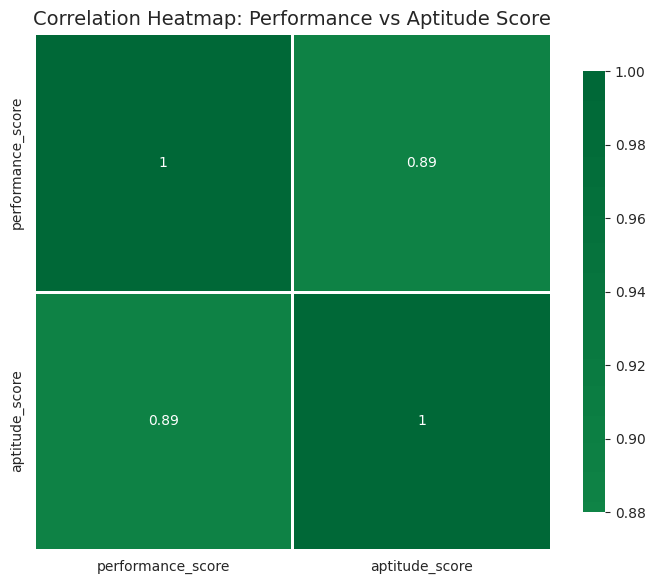

In [36]:
# --- Calculate Correlation Matrix ---
# Select only the two columns we want to compare
corr_matrix = df[['performance_score', 'aptitude_score']].corr()

# ---  Setup Styling ---
# Use white background so the white lines between heatmap squares are visible
sns.set_style("white")
plt.figure(figsize=(7, 6))

# --- Draw the Heatmap ---
sns.heatmap(
    corr_matrix,
    annot=True,          # Show the numbers (0.89, 1) in the squares
    cmap='RdYlGn',       # Red-Yellow-Green colormap (matches the red in your image)
    center=0,            # centers the colormap
    vmin=0.88, vmax=1,   # Limits the color range to make the red intense (since correlation is high)
    linewidths=2,        # Width of the white lines between squares
    linecolor='white',   # Color of the lines
    square=True,         # Forces squares to be perfect squares
    cbar_kws={"shrink": 0.8} # Slightly shrinks the color bar on the right
)

# --- Customization ---
plt.title('Correlation Heatmap: Performance vs Aptitude Score', fontsize=14)

plt.tight_layout()
plt.show()

# Chapter 8: Effect Sizes (Cohen's d)

In [37]:
# --- Helper Functions ---

# Function to calculate Cohen's d (Effect Size)
def calculate_cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Pooled Standard Deviation
    numerator = ((n1 - 1) * var1) + ((n2 - 1) * var2)
    denominator = n1 + n2 - 2
    pooled_sd = np.sqrt(numerator / denominator)

    # Cohen's d
    return (np.mean(group1) - np.mean(group2)) / pooled_sd

# Function to interpret Effect Size
def interpret_effect(d):
    d = abs(d)
    if d >= 1.2: return "Very Large"
    if d >= 0.8: return "Large"
    if d >= 0.5: return "Medium"
    return "Small"

# --- 3. Perform Pairwise Comparisons ---
comparisons = [
    ('Advanced', 'Intermediate'),
    ('Intermediate', 'Foundation'),
    ('Advanced', 'Foundation')
]

rows = []

for label1, label2 in comparisons:
    # Get the Aptitude Scores for the two groups
    g1 = df[df['course_level'] == label1]['aptitude_score']
    g2 = df[df['course_level'] == label2]['aptitude_score']

    # Calculate Stats
    diff = g1.mean() - g2.mean()
    t_stat, p_val = stats.ttest_ind(g1, g2)
    d_val = calculate_cohens_d(g1, g2)

    # Format Row
    rows.append({
        'Comparison': f"{label1} vs {label2}",
        'Difference': f"{diff:.1f} points",
        'p-value': "<0.001" if p_val < 0.001 else f"{p_val:.3f}",
        'Effect Size': f"{d_val:.2f}",
        'Interpretation': interpret_effect(d_val)
    })

# --- 4. Display Table ---
results = pd.DataFrame(rows)

# Adjust display settings to ensure full table visibility
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
print("Comparing Specific Pairs of Levels\n")
print("Pairwise Aptitude Comparisons")
display(results)

Comparing Specific Pairs of Levels

Pairwise Aptitude Comparisons


,Comparison,Difference,p-value,Effect Size,Interpretation
0,Advanced vs Intermediate,24.7 points,<0.001,1.32,Very Large
1,Intermediate vs Foundation,20.2 points,<0.001,1.46,Very Large
2,Advanced vs Foundation,44.9 points,<0.001,3.11,Very Large


# Chapter 9: Comprehensive Visualizations

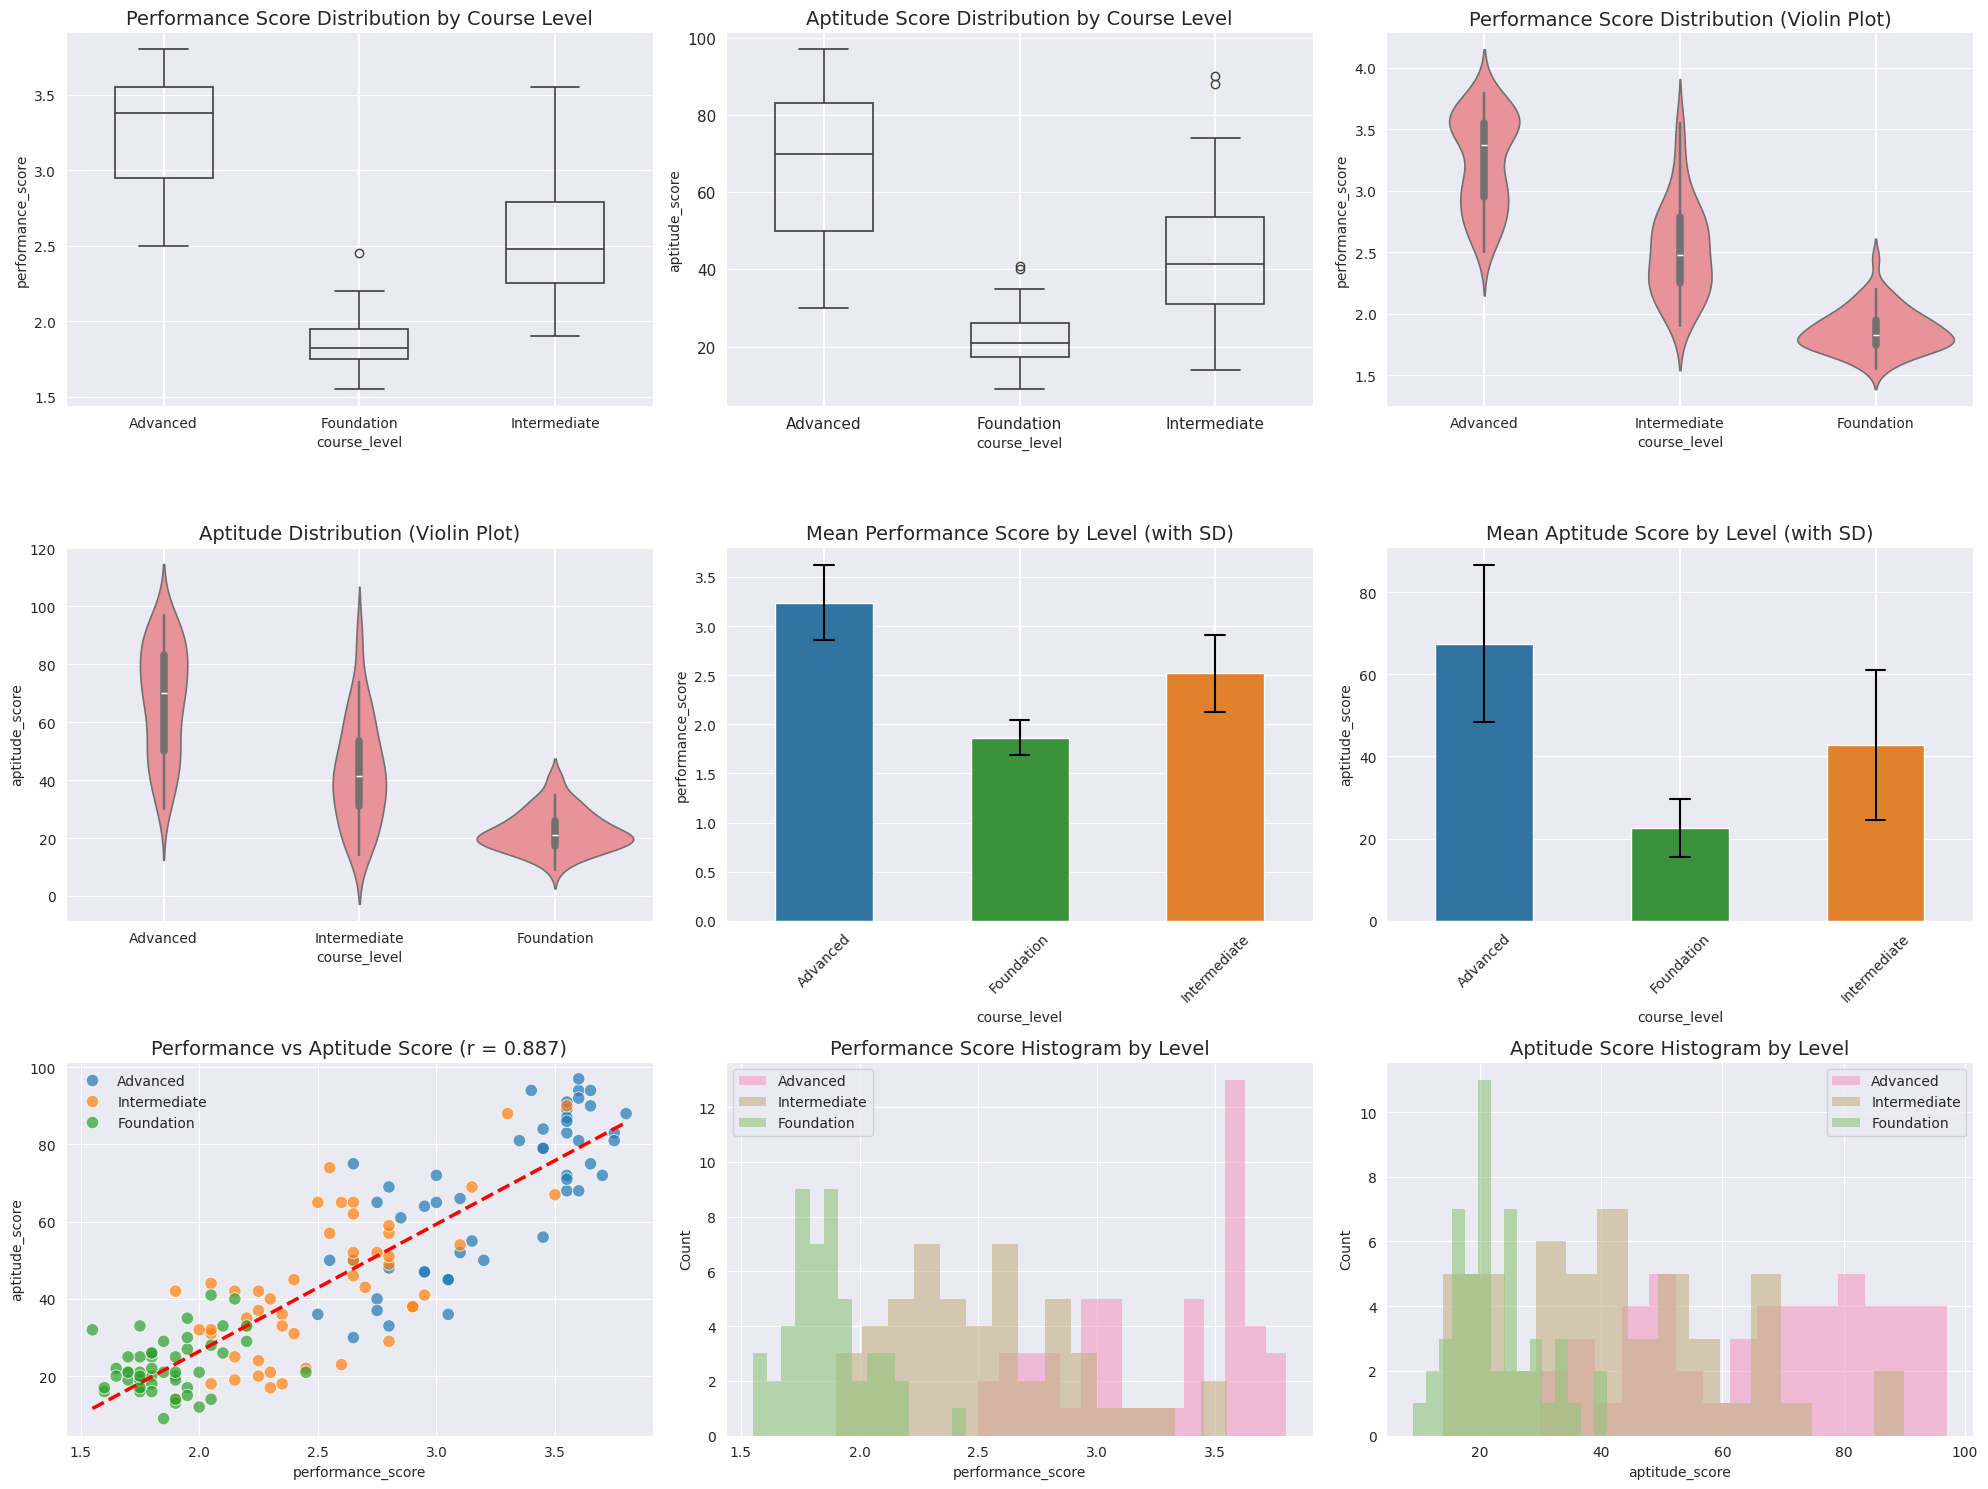

In [38]:
# --- Setup Figure ---
sns.set_style("darkgrid")
# Create a 3x3 Grid (3 Rows, 3 Columns)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Increase vertical spacing so titles don't overlap
plt.subplots_adjust(hspace=0.4)

# ==========================================
# ROW 1: Boxplots & Performance Violin
# ==========================================

# 1.1 Performance Boxplot (Left)
sns.boxplot(
    data=df, x='course_level', y='performance_score',
    order=['Advanced', 'Foundation', 'Intermediate'],
    boxprops=dict(facecolor=(0,0,0,0)), # Transparent
    width=0.5, linewidth=1.2, fliersize=6,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Performance Score Distribution by Course Level', fontsize=14)
axes[0, 0].grid(axis='x', color='white', linestyle='-', linewidth=1.5)

# 1.2 Aptitude Boxplot (Middle)
sns.boxplot(
    data=df, x='course_level', y='aptitude_score',
    order=['Advanced', 'Foundation', 'Intermediate'],
    boxprops=dict(facecolor=(0,0,0,0)), # Transparent
    width=0.5, linewidth=1.2, fliersize=6,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Aptitude Score Distribution by Course Level', fontsize=14)
axes[0, 1].tick_params(axis='both', which='major', labelsize=11)
axes[0, 1].grid(axis='x', color='white', linestyle='-', linewidth=1.5)

# 1.3 Performance Violin Plot (Right)
sns.violinplot(
    data=df, x='course_level', y='performance_score',
    order=['Advanced', 'Intermediate', 'Foundation'],
    color='#F6848F', inner='box', linewidth=1.2,
    ax=axes[0, 2]
)
axes[0, 2].set_title('Performance Score Distribution (Violin Plot)', fontsize=14)
axes[0, 2].grid(axis='x', color='white', linestyle='-', linewidth=1.5)


# ==========================================
# ROW 2: Aptitude Violin & Bar Charts
# ==========================================

# 2.1 Aptitude Violin Plot (Left)
sns.violinplot(
    data=df, x='course_level', y='aptitude_score',
    order=['Advanced', 'Intermediate', 'Foundation'],
    color='#F6848F', inner='box', linewidth=1.2,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Aptitude Distribution (Violin Plot)', fontsize=14)
axes[1, 0].grid(axis='x', color='white', linestyle='-', linewidth=1.5)

# 2.2 Mean Performance Bar Plot (Middle)
sns.barplot(
    data=df, x='course_level', y='performance_score',
    order=['Advanced', 'Foundation', 'Intermediate'],
    errorbar='sd', capsize=0.1, width=0.5,
    hue='course_level', legend=False,
    err_kws={'color': 'black', 'linewidth': 1.5},
    ax=axes[1, 1]
)
axes[1, 1].set_title('Mean Performance Score by Level (with SD)', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='x', color='white', linestyle='-', linewidth=1.5)

# 2.3 Mean Aptitude Bar Plot (Right)
sns.barplot(
    data=df, x='course_level', y='aptitude_score',
    order=['Advanced', 'Foundation', 'Intermediate'],
    errorbar='sd', capsize=0.1, width=0.5,
    hue='course_level', legend=False,
    err_kws={'color': 'black', 'linewidth': 1.5},
    ax=axes[1, 2]
)
axes[1, 2].set_title('Mean Aptitude Score by Level (with SD)', fontsize=14)
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(axis='x', color='white', linestyle='-', linewidth=1.5)


# ==========================================
# ROW 3: Correlation & Histograms
# ==========================================

# 3.1 Scatter Plot with Regression (Left)
# Calculate Correlation
import scipy.stats as sps # Local import and alias to avoid name collision with 'stats' DataFrame variable
r, p = sps.pearsonr(df['performance_score'], df['aptitude_score'])

sns.scatterplot(
    data=df, x='performance_score', y='aptitude_score',
    hue='course_level', s=80, alpha=0.7, palette='tab10',
    ax=axes[2, 0]
)
sns.regplot(
    data=df, x='performance_score', y='aptitude_score',
    scatter=False, ci=None, line_kws={"color": "red", "ls": "--", "linewidth": 2.5},
    ax=axes[2, 0]
)
axes[2, 0].set_title(f'Performance vs Aptitude Score (r = {r:.3f})', fontsize=14)
axes[2, 0].legend(loc='upper left', frameon=False)

# Custom Colors for Histograms
colors = {'Advanced': '#F49AC2', 'Intermediate': '#C4B083', 'Foundation': '#93C47D'}

# 3.2 Performance Histogram (Middle)
for level, color in colors.items():
    sns.histplot(
        data=df[df['course_level'] == level], x='performance_score',
        bins=15, alpha=0.6, color=color, label=level, edgecolor=None, linewidth=0,
        ax=axes[2, 1]
    )
axes[2, 1].set_title('Performance Score Histogram by Level', fontsize=14)
axes[2, 1].legend(labels=['Advanced', 'Intermediate', 'Foundation'])

# 3.3 Aptitude Histogram (Right)
for level, color in colors.items():
    sns.histplot(
        data=df[df['course_level'] == level], x='aptitude_score',
        bins=15, alpha=0.6, color=color, label=level, edgecolor=None, linewidth=0,
        ax=axes[2, 2]
    )
axes[2, 2].set_title('Aptitude Score Histogram by Level', fontsize=14)
axes[2, 2].legend(labels=['Advanced', 'Intermediate', 'Foundation'])

# --- Final Layout ---
plt.tight_layout()
plt.show()

# Chapter 10: Summary and Conclusions